In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

*Welcome!*

This notebook contains the analysis and development of a predictive model of [airlinemeals.net](https://www.airlinemeals.net) meal ratings. This is a public website (see image below) on which passengers can upload photos, descriptions and comments but most importantly the rating of a meal they consumed on board. In this notebook a predictive model of this rating is created.

The below table of contents briefly outlines this project:
* [1:](#chapter1) Importing the dataset and cleaning the data
    * [1.1:](#dataprep) Preparing the data for further analysis 
* [2:](#chapter3-1) Creating the meal contents variables
* [3:](#chapter4) Developing a predictive model
    * [3.1:](#4.1) Decision Tree Regressor
    * [3.2:](#4.2) Other ML models
* [Conclusion](#conclusion)



In [2]:
Image(url= "https://www.airlinemeals.net/images/new-howto/00-airlinemeals-new-full-site2.jpg", width=500, height=500)

In [3]:
import pandas as pd
import re
import nltk
from nltk import bigrams
from nltk import ngrams
import unicodedata
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
nltk.download('stopwords')
nltk.download('wordnet')

/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elskedenbode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elskedenbode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1: <a class="anchor" id="chapter1"></a>Importing the dataset and cleaning the data

Download the dataset [here](https://drive.google.com/file/d/13gNELaGfO8H52BcH3PXvIxIrkQhFYJFh/view?usp=sharing) and import the dataset.

In [4]:
df = pd.read_csv('airline_meals.csv')
df_data_str = df.astype(str)

The 'Flight' column contains more information soures. This column will therefore be splitted.

In [5]:
#splitting the information column into five columns
df_data_str[['Date_added', 'Flight_no', 'Flight_duration', 'AC_type', 'Other_comments']] = pd.DataFrame(df_data_str['Info'].str.split('//',4).tolist(),
                                 columns = ['Date_added', 'Flight_no', 'Flight_duration', 'AC_type', 'Other_comments'])
#Splitting route and date into two seperate columns
df_data_str[['Route','Date_flight']] = pd.DataFrame(df_data_str['Flight'].str.split(',',1).tolist(),
                                 columns = ['Route','Date_flight'])

Prefixes to the information, such as annoucing the aircraft type with 'Aircraft:' are removed

In [6]:
#removing unneccessary information from columns
df_data_str['AC_type'].replace('Aircraft:', '', regex=True, inplace=True)
df_data_str['Flight_duration'].replace('Flight:', '', regex=True, inplace=True)
df_data_str['Date_added'].replace('Date added:', '', regex=True, inplace=True)

#cleaning target variable
df_data_str['Rating'].replace('/10', '', regex=True, inplace=True)
df_data_str['Airline'].replace("[\(\[].*?[\)\]]", "", regex=True, inplace=True)

## 1.1 Data preparation: Adjusting column types for analysis <a class="anchor" id="dataprep"></a>
In this section the following steps are taken
1. 'Rating', the target variable, is converted to string and the 'Date_flight' converted to datetime
2. 'Ticket_price' is extracted.
3. 'Description' and 'Info' columns are combined for further analysis as similar information is captured in both columns.
3. Flight duration is extracted and converted to minutes
4. Aircraft types are converted into dummy variables

In [7]:
#Step 1: adjusting 'Rating' to numeric and 'Date_flight' to datetime
df_data_str['Rating'] = pd.to_numeric(df_data_str['Rating'])
df_data_str['Date_flight'] = pd.to_datetime(df_data_str['Date_flight'], errors='coerce')

In [8]:
#Step 2: Get ticket
df_data_str['Ticket_pricing_full'] = df_data_str['Info'].str.extract('(.Ticket price\: [0-9].*.)')
df_data_str['Ticket_pricing'] = df_data_str['Ticket_pricing_full'].str.extract('([0-9]+)')
df_data_str['Ticket_pricing'] = pd.to_numeric(df_data_str['Ticket_pricing'])

#Step 3: All string columns to one 
df_data_str = df_data_str.assign(Product=lambda x: (x['Description'] + x['Meal'] + x['Info'] + x['Drink'])) 
df_data_str = df_data_str.assign(Productmeals=lambda x: (x['Description'] + x['Meal'] + x['Info'])) 

#Step 4: Flight duration to numeric
df_data_str['Flight_duration'] = df_data_str['Info'].str.extract('([0-9]+\:[0-9]+)')

In [9]:
#Step 4: Converting the length of flight to number of minutes
def get_min(time_str):
    """Get minutes from time."""
    h, m = time_str.split(':')
    return int(h) * 60 + int(m)

#first filling NA with 0:0 so the time can be appropriately converted to 0 by the above function
df_data_str['Length_of_flight'] = df_data_str['Flight_duration'].fillna('0:0')

#applying the function to get the time in minutes in ['Length_of_flight_mins']
df_data_str['Length_of_flight_mins'] = df_data_str['Length_of_flight'].apply(lambda x: get_min(str(x)))

In [10]:
#Step 5: converting AC_type to dummy variable

#Printing the current number of AC_types in the dataset
print("There are", (len(df_data_str['AC_type'].unique())), "different AC_types in the dataset")

There are 2106 different AC_types in the dataset


It is therefore important to clean up this variable and create a dummy variable for the most common aircraft types.

In [11]:
#Step 5: Creating matches for ac types. Fokker, embraer, bombardier are seldomly used so can be classified as "other"
matches_boeing = ["Boeing 777-300ER", "777", "767", "737", "757", "747", "787", "789"]
matches_airbus = ["Airbus", "A321", "321", "320", "380", "350", "320", "319", "330"]
matches_other = ['Fokker', 'Emb', 'Embraer','Bombardier']

#making dummy variables
df_data_str['Aircraft_Boeing'] = df_data_str['Info'].apply([lambda x: 1 if any(i in str(x) for i in matches_boeing) else 0])
df_data_str['Aircraft_Airbus'] = df_data_str['Info'].apply([lambda x: 1 if any(i in str(x) for i in matches_airbus) else 0])
df_data_str['Aircraft_Other'] = df_data_str['Info'].apply([lambda x: 1 if any(i in str(x) for i in matches_other) else 0])

print("There now are",df_data_str['Aircraft_Boeing'].value_counts()[1], "flights on Boeing aircraft")
print("There now are",df_data_str['Aircraft_Airbus'].value_counts()[1], "flights on Airbus aircraft")

There now are 3843 flights on Boeing aircraft
There now are 3223 flights on Airbus aircraft


#  2: Creating the 'meal_***' contents variables
<a class="anchor" id="chapter3-1"></a>
In order to get more information on the contents of the meals that were rated on airlinemeals.net, a textual analysis using NLTK libraries is performed. The following steps are taken:
1. Common stopwords used in both the meal and description string variables that do not relate to the actual contents of the meal are collected.
2. The text in both 'Meal' and 'Description' are appended in one large list for further analysis.
3. Ngram and bigram analysis are performed to identify the most common classes of meals served.
4. Dummy variables are created, 1 means the meal has contents in that category, and 0 means it does not.

After this step all the variables have been created and helper columns can be removed.

In [12]:
#Step 1: additional stopwords are created to later on append to the NLTK stopwords library. These stopwords are based on words that appeared on the n-gram analysis that do not indicate meal contents
additional_stopwords = ['special', 'breakfast', 'card', 'aircraft', '737800', 'ticket', 'price', '777300er', 'airbus', 'nan', ' boeing', '777', 'date', 'added', 'xa0', 'nice', 'choose', 'lunch', '2', 'meal', 'served', 'menu', 'served', 'flight', 'dinner', 'description', 'class', 'economy', ' business', 'service', 'equipment']

In [13]:
#Step 2.1 Appending the text from the function
text = []
nott = (' (no description)')

#Function that creates one large string of text for further analysis
def get_text(listy):
    for x in listy:
        words = x.split(',')
        for i in words:
            if i != nott:
                text.append(i.split('\t')[0])
            
#Call the function            
get_text(df_data_str['Productmeals'])

In [14]:
#Step 2.2 Lemmatizing the words, ignoring stopwords

#Defining the function
def get_words(text):

    wnl = nltk.stem.WordNetLemmatizer()
    stop_words = nltk.corpus.stopwords.words('english') + additional_stopwords 
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub('[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stop_words]

#Calling the function
words = get_words(''.join(str(text)))

Text(0.5, 0, '# of Occurences')

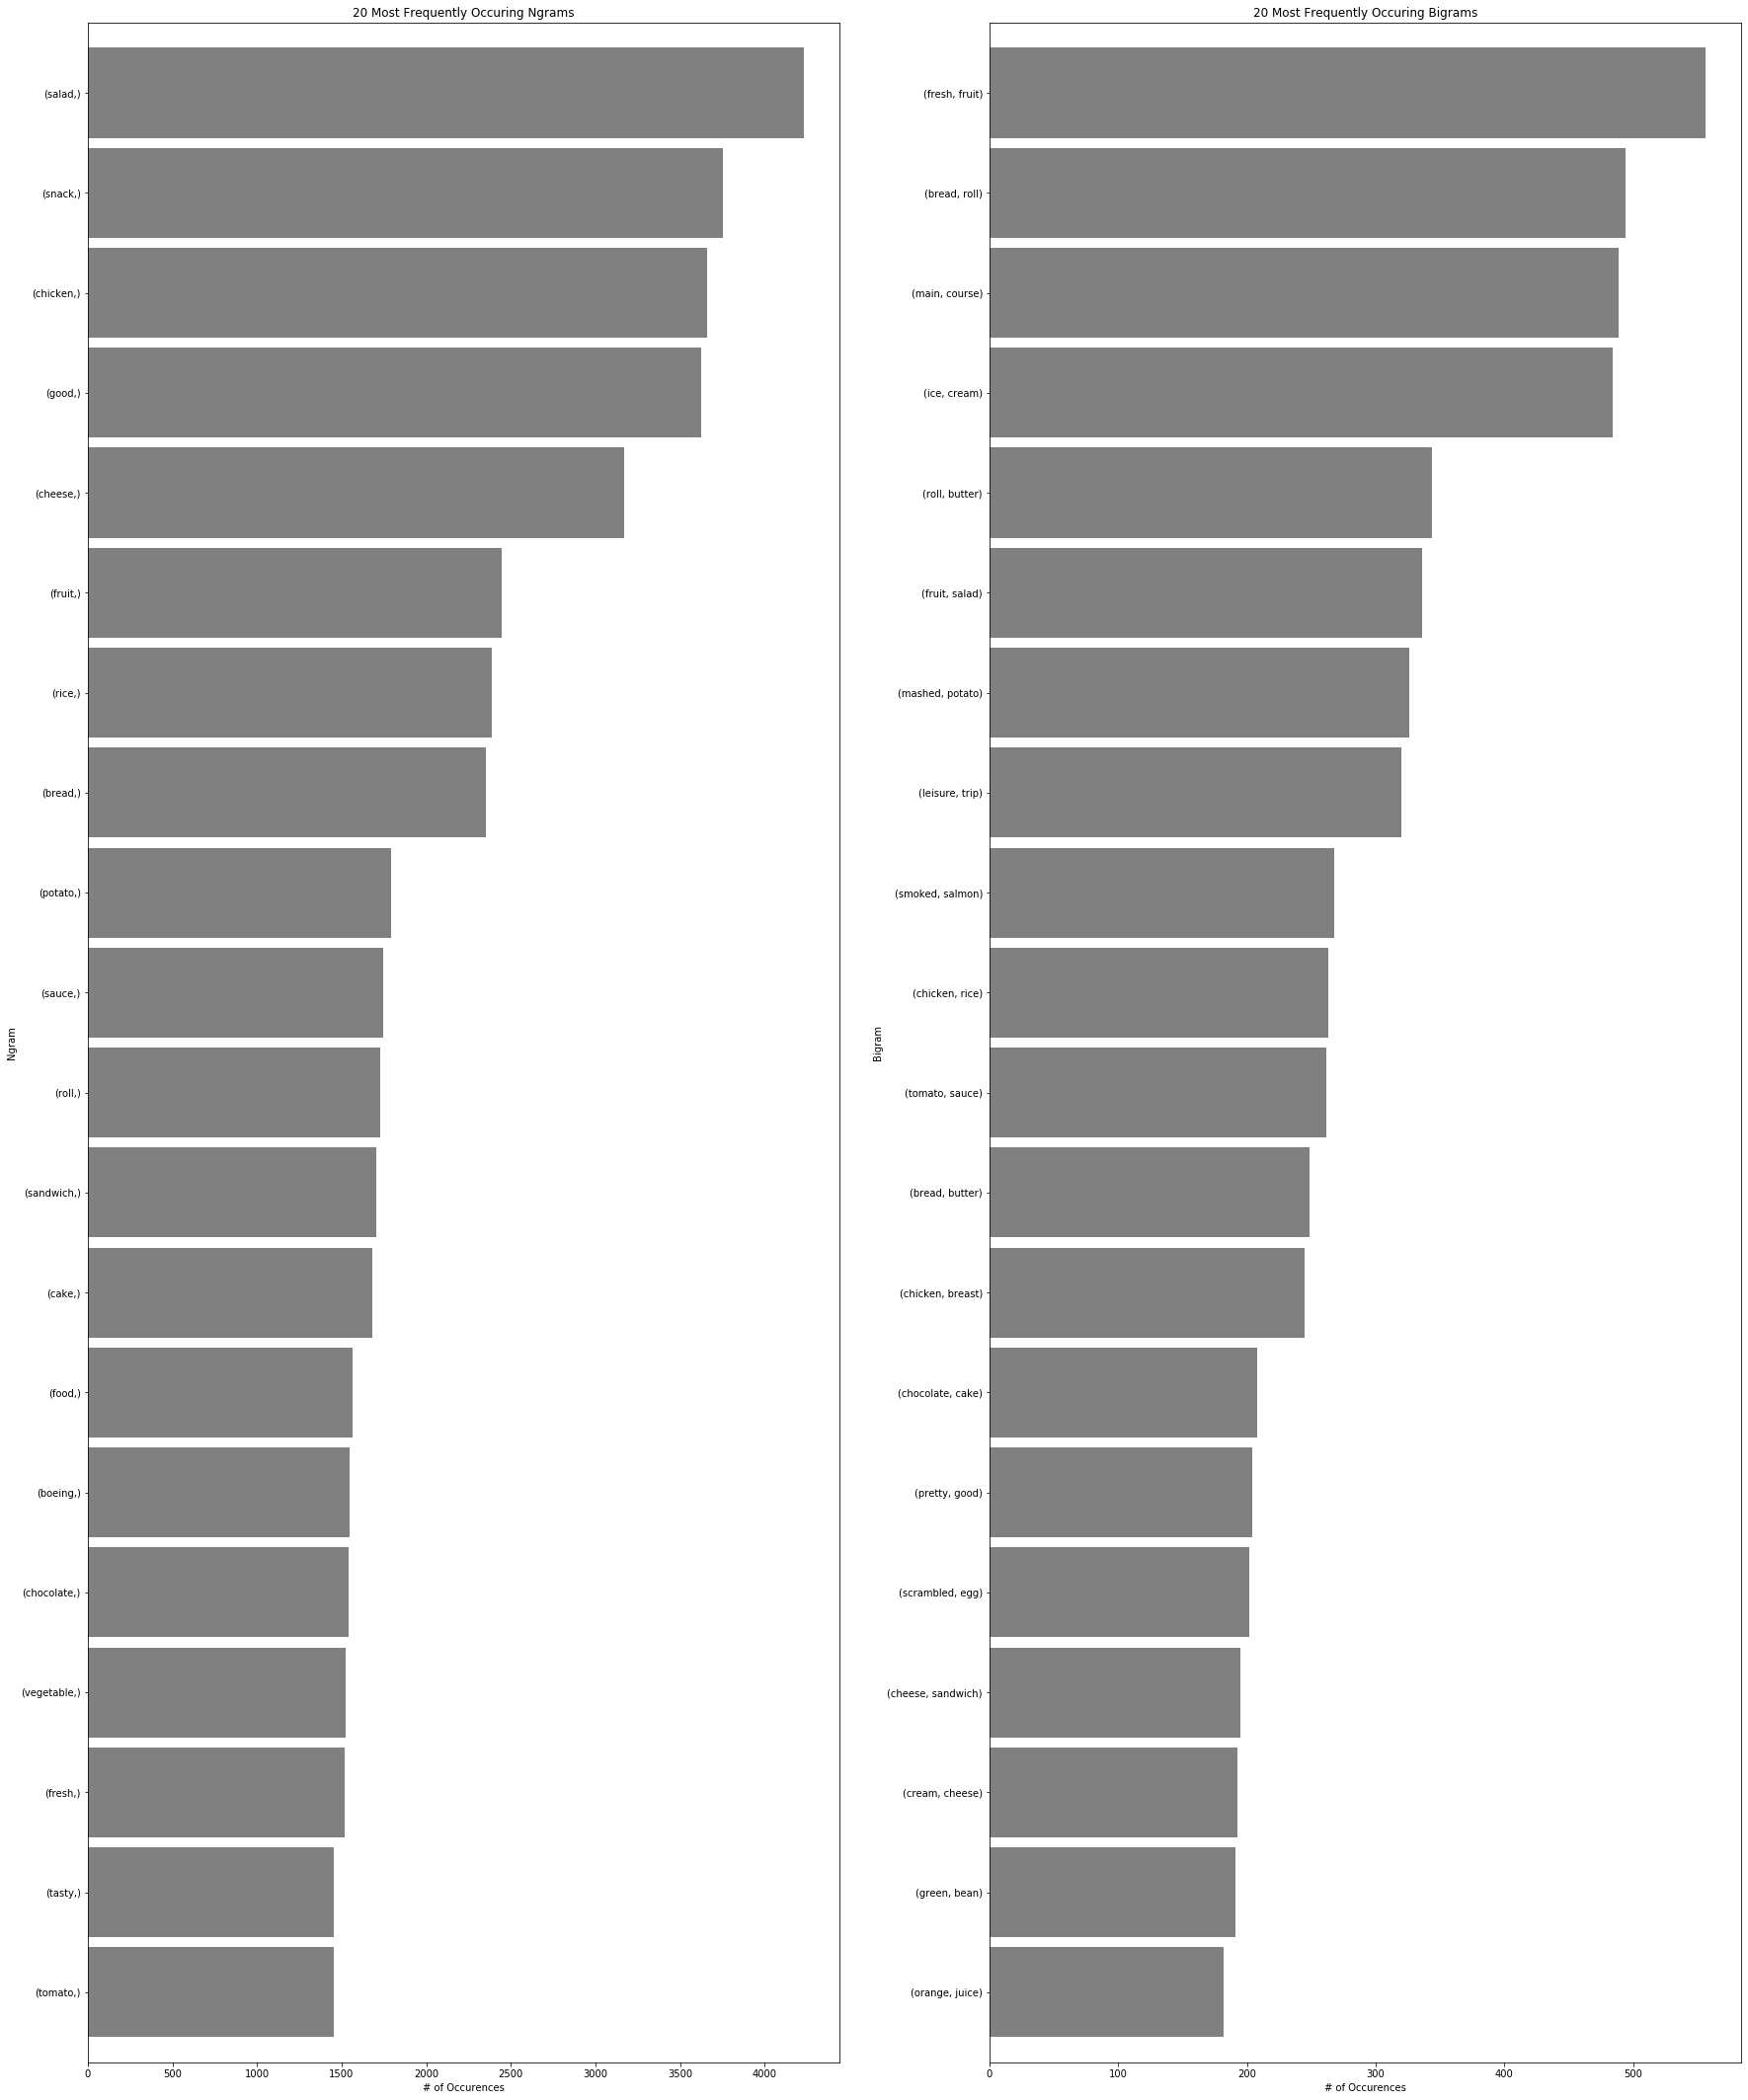

In [15]:
#Step 3.1 Creating ngram analysis of single words and plotting the first 20 most common meal contents
ax =  plt.subplot(1, 2, 1)
ngrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[0:20]
ngrams_series.sort_values().plot.barh(color='grey', width=.9, figsize=(12, 18), ax=ax)
plt.title('20 Most Frequently Occuring Ngrams')
plt.ylabel('Ngram')
plt.xlabel('# of Occurences')

ax = plt.subplot(1, 2, 2)
#Step 3.1 Creating bigram-analysis and plotting the first 20 most common meal contents
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[0:20]
bigrams_series.sort_values().plot.barh(color='grey', width=.9, figsize=(30, 38), ax=ax)
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurences')

In [16]:
#making classes of meals and ingredients based upon the ngram and bigram analysis
matches_poultry = ["chicken", "turkey", "duck", "chiken", "pheasant", "geese", "goose"]
matches_meat = ["beef", "meat", "tenderloin", "meatball", "steak", "veal", "lamb"]
matches_fish = ["fish", "seafood", "shrimp", "cod", "salmon"]
matches_vegetarian = ["vegetarian", "tofu", "veggie", "veg"]
matches_asian = ["noodles", "dimsum", "dumpling", "dumplings"]
matches_western = ["potatoe", "schnitzel", "croissant"]
matches_italian = ["tomato", "spaghetti", "penne", "lasagna", "pizza", "pasta"]
matches_dairy = ["yoghurt", "milk", "cream", "custard", "icecream", "cheese", "butter"]
matches_sweets = ["brownie", "chocolate", "cake", "sweet", "sweetcake"]
matches_alcohol = ["wine", "beer", "gin", "whiskey", "bloody", "vodka", "alcoholic", "champagne", "redwine", "whitewine", "g and t"]

#making dummy variables
df_data_str['Meal_poultry'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_poultry) else 0])
df_data_str['Meal_meat'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_meat) else 0])
df_data_str['Meal_fish'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_fish) else 0])
df_data_str['Meal_vegetarian'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_vegetarian) else 0])
df_data_str['Meal_italian'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_italian) else 0])
df_data_str['Meal_asian'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_asian) else 0])
df_data_str['Meal_western'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_western) else 0])
df_data_str['Meal_sweets'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_sweets) else 0])
df_data_str['Meal_alcohol'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_alcohol) else 0])
df_data_str['Meal_dairy'] = df_data_str['Product'].apply([lambda x: 1 if any(i in str(x) for i in matches_dairy) else 0])

In [17]:
#printing the occurences of the meals
print("There were", df_data_str['Meal_poultry'].value_counts()[1], "meals served with poultry")
print("There were", df_data_str['Meal_vegetarian'].value_counts()[1], "vegetarian meals served")
print("There were", df_data_str['Meal_meat'].value_counts()[1], "meals served with meat")
print("There were", df_data_str['Meal_fish'].value_counts()[1], "meals served with fish")
print("There were", df_data_str['Meal_italian'].value_counts()[1], "italian meals served")
print("There were", df_data_str['Meal_asian'].value_counts()[1], "asian meals served")
print("There were", df_data_str['Meal_dairy'].value_counts()[1], "meals served containing dairy")
print("There were", df_data_str['Meal_western'].value_counts()[1], "western meals served")
print("There were", df_data_str['Meal_sweets'].value_counts()[1], "meals served with sweets")
print("There were", df_data_str['Meal_alcohol'].value_counts()[1], "meals served with alcoholic beverages")

There were 2126 meals served with poultry
There were 1712 vegetarian meals served
There were 1430 meals served with meat
There were 1350 meals served with fish
There were 1876 italian meals served
There were 350 asian meals served
There were 3902 meals served containing dairy
There were 1159 western meals served
There were 2910 meals served with sweets
There were 2430 meals served with alcoholic beverages


Finally, we drop some columns that are no longer necessary

In [18]:
df_data_str.drop(df_data_str.index[df_data_str['Product'].str.contains(r'description') == True], inplace=True)

#Dropping no longer neccessary columns
df_data_str.drop(columns=['Ticket_pricing_full', 'Airline', 'Route'], inplace=True)
df_data_str.drop(columns=['Flight_no', 'Flight', 'Meal', 'Drink', 'AC_type', 'Other_comments'], inplace=True)
df_data_str.drop(columns=['Info', 'Description', 'Class', 'Flight_duration', 'Productmeals'], inplace=True)
df_data_str.drop(columns=['Date_added', 'Date_flight', 'Product', 'Length_of_flight'], inplace=True)
df_data_str = df_data_str.loc[:, ~df_data_str.columns.str.contains('^Unnamed')]

#Drop columns that do not have a ticket price
#df_data_str.dropna(subset=['Ticket_pricing'], inplace=True)

In [19]:
#Ensure all variabels are numeric
cols = df_data_str.columns[-13:]
df_data_str[cols] = df_data_str[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# 3: Developing a predicting model <a class="anchor" id="chapter4"></a>

In this chapter a predictive model is built. As we want to predict the 'Rating', which is distributed as follows: 

Text(0.5, 1.0, 'Distribution of Ratings')

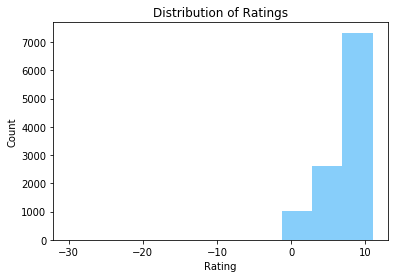

In [20]:
#Plotting a histogram of ratings
plt.hist(df_data_str['Rating'], bins = 10, color="lightskyblue")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

Following, the correlations with this variable are calculated.

In [21]:
#print the correlations between the variables and print
(df_data_str.corr()['Rating'].sort_values(ascending=False).head(20))

Rating                   1.000000
Meal_alcohol             0.063922
Aircraft_Airbus          0.063404
Meal_fish                0.062127
Meal_dairy               0.051071
Meal_western             0.048728
Meal_poultry             0.048165
Meal_meat                0.035808
Meal_italian             0.032235
Meal_sweets              0.032013
Length_of_flight_mins    0.026922
Meal_vegetarian          0.012083
Meal_asian               0.007326
Aircraft_Boeing          0.004679
Aircraft_Other          -0.007006
Ticket_pricing          -0.020037
Name: Rating, dtype: float64

The correlations are rather weak. Numeric values such as the length of flight and the ticket price could contain outliers that influence the correlation. To identify this a boxplot and scatterplot (in relation to 'Rating') were visualized. These graphs and the rationale to remove outliers for these two variables is indicated below.

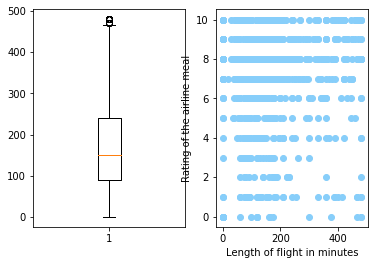

In [50]:
#Removing outliers. Outliers in ticket prices can be removed as flights can not take longer than 18 hours, the longest flight in the world.
y = df_data_str['Length_of_flight_mins']
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))
index_names = df_data_str[~removed_outliers].index
df_data_str.drop(index_names, inplace=True)

#Plotting a boxplot
ax =  plt.subplot(1, 2, 1)
plt.boxplot(df_data_str['Length_of_flight_mins'])

#Plotting a scatterplot
ax = plt.subplot(1, 2, 2)
plt.scatter(df_data_str['Length_of_flight_mins'], df_data_str['Rating'], color='lightskyblue')
plt.xlabel('Length of flight in minutes')
plt.ylabel('Rating of the airline meal')
plt.show()

Text(0, 0.5, 'Rating of the airline meal')

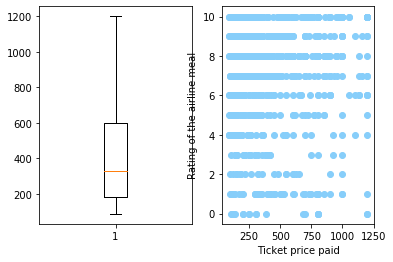

In [48]:
#Removing outliers. Outliers in ticket prices can be removed as these may be currency values that do not convert well or prices paid for business class tickets.
y = df_data_str['Ticket_pricing']
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))
index_names = df_data_str[~removed_outliers].index
df_data_str.drop(index_names, inplace=True)

#Plotting a boxplot
ax =  plt.subplot(1, 2, 1)
plt.boxplot(df_data_str['Ticket_pricing'])

#Plotting a scatterplot
ax = plt.subplot(1, 2, 2)
plt.scatter(df_data_str['Ticket_pricing'], df_data_str['Rating'], color="lightskyblue")
ax.set_xlabel('Ticket price paid')
ax.set_ylabel('Rating of the airline meal')
#plt.show()

We will verify if the correlations have improved:

In [51]:
#print the correlations between the variables and print
(df_data_str.corr()['Rating'].sort_values(ascending=False).head(20))

Rating                   1.000000
Meal_dairy               0.128286
Meal_sweets              0.113771
Meal_italian             0.083704
Length_of_flight_mins    0.052021
Meal_vegetarian          0.047266
Meal_western             0.045819
Meal_poultry             0.040149
Meal_meat                0.038388
Meal_fish                0.037791
Aircraft_Boeing          0.021109
Ticket_pricing           0.008851
Aircraft_Airbus         -0.001835
Meal_alcohol            -0.002652
Aircraft_Other          -0.023172
Meal_asian              -0.037830
Name: Rating, dtype: float64

They did not significantly improve. Nevertheless the analysis is continued. Improvement to the dataset might be added later. We continue with the following variables:

In [25]:
#print the correlations between the variables and print
df_data_str

,Rating,Ticket_pricing,Length_of_flight_mins,Aircraft_Boeing,Aircraft_Airbus,Aircraft_Other,Meal_poultry,Meal_meat,Meal_fish,Meal_vegetarian,Meal_italian,Meal_asian,Meal_western,Meal_sweets,Meal_alcohol,Meal_dairy
9,8,100.0,140,0,1,0,0,0,0,1,0,0,0,1,1,0
30,6,8850.0,270,1,0,0,1,1,0,0,1,1,1,0,0,0
97,10,395.0,400,1,0,0,0,0,0,1,0,0,1,0,0,0
98,10,195.0,90,0,1,0,0,0,0,0,0,0,0,0,0,0
105,4,55.0,60,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11670,4,1320.0,220,0,1,0,0,0,0,0,0,0,0,0,0,0
11690,8,2700.0,715,0,1,0,0,0,1,1,0,0,0,0,1,1
11691,8,2700.0,150,0,1,0,1,0,0,0,1,0,0,1,0,1
11718,6,400.0,240,1,1,0,0,0,0,0,0,0,1,0,0,0


Below, the dataset is splitted into the features and the target variable. Then the test set of 20% is splitted.

In [52]:
X = df_data_str.drop('Rating', axis=1)
y = df_data_str['Rating']

from sklearn.model_selection import train_test_split
# df is features and labels are the targets 
# Split by putting 20% in the testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.20, random_state=42)

## 3.1 Decision Tree Regressor<a class="anchor" id="4.1"></a>

A Decision Tree Regressor is chosen as the first model to predict airline meal ratings with. This is because the dataset includes **non-linear and separable data**, the model is **simple to use and explain** and also important, it's **fast**.

We start with importing and fitting the model to the data. Then the model predicts and these scores are printed in the dataframe below.


In [53]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [54]:
y_pred = regressor.predict(X_test)

In [55]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head(20)

,Actual,Predicted
9276,6,1.0
5911,7,7.0
2424,10,3.0
4762,8,6.0
5235,9,10.0
6493,5,8.5
5610,6,3.0
2687,1,1.0
8473,0,8.0
11424,7,8.0


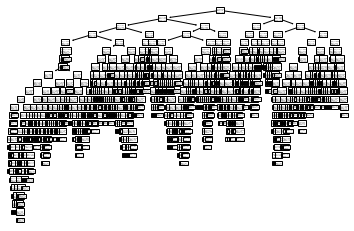

In [30]:
from sklearn import tree
tree.plot_tree(regressor);

In [56]:
from sklearn import metrics
import numpy as np
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.11
Mean Squared Error: 17.248333333333335
Root Mean Squared Error: 4.1531112835238755


## 3.2 Other ML models<a class="anchor" id="4.2"></a>

In this section the performance of several other ML models is assessed to derive their potential further analysis. First the needed libraries are imported, then a function is created to loop through these models efficiently. The results in terms of the evaluation of these models is summarized in two graphs.

In [43]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [44]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

results = evaluate(X_train, X_test, y_train, y_test)
#Credit function: https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb

In [45]:
df_data_str['Rating'].mean()

6.839357429718875

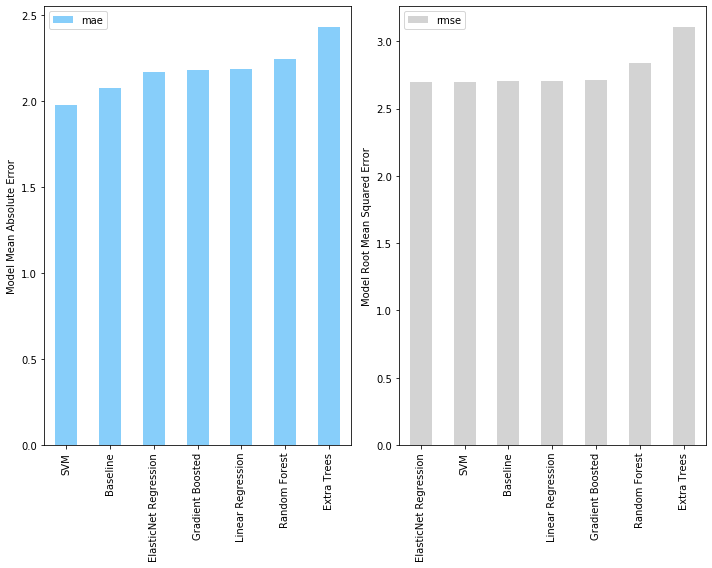

In [46]:
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'lightskyblue', ax = ax, figsize=(10,8))
plt.ylabel('Model Mean Absolute Error');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'lightgrey', ax = ax)
plt.ylabel('Model Root Mean Squared Error');

#Credit function: https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb
plt.tight_layout()

The Extra Trees, Random Forst en SVM are potentially valuable models for this dataset. Their Mean Absolute Error below 1 could potentially be improved in further analysis.

# Conclusion<a class="anchor" id="conclusion"></a>

In this notebook we have analysed reviews on airline meals, collected from airlinemeals.net. The data was retrieved and cleaned. The columns have been prepared for further analysis. Some important adjustments were made to the data, for example:

- The duration of the flight was adjusted to duration in minutes
- The aircraft type was transformed to dummy variables and distinguishes between Airbus and Boeing only
- The reviewed meals were described in either the 'Meal' column or 'Description', both these columns were analyzed using NLTK libraries to create ngram and bigrams for the meals.
- Subsequently, this analysis was used to create dummy variables for the contents of the meal that was reviewed. These included, e.g. poultry, meat or fish meals and italian, asian, vegetarian meals. Also whether the meal was served with an alcoholic beverage was taken into account.

The analysis continued with a Decision Tree Regressor analysis. This model predicted the airline meal ratings with mediocre accuracy. The following bullet points list the evaluation scores:
- Mean Absolute Error: 2.73972602739726
- Mean Squared Error: 13.002283105022832
- Root Mean Squared Error: 3.605867871265229

Knowing that the mean rating given to the meals in this data set is: 7.13, the Mean Absolute Error of 0.7 is approximately 10% of the dataset's mean.

Following the Decision Tree Regressor analysis, a list of several other standard machine learning models were reviewed to consider the performance of other models. From this it was concluded that Extra Trees and Random Forest should be considered in follow-up analysis.
